In [41]:
from typing import TypedDict, List, Dict, Any, Literal, Callable, NamedTuple
import json
from pydantic import BaseModel, Field
import random
from langgraph.graph import StateGraph, END
from openai import OpenAI
from sklearn.model_selection import train_test_split
import pandas as pd


In [42]:
from tenacity import retry, stop_after_attempt, wait_exponential

client = OpenAI()

@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=2, max=10))
def llm_call(system_prompt: str, prompt: str, OutputFormat: BaseModel, temperature=0.7, model: str = "gpt-4o"):
    llm_out = client.responses.parse(
        temperature=temperature,
        model=model,
        input=[{"role": "system", "content": system_prompt},
               {"role": "user", "content": prompt}],
        text_format=OutputFormat,
    )
    llm_out = llm_out.output_parsed
    return llm_out

In [ ]:
# Configuration
MAX_ITERATIONS = 10
TARGET_SCORE = 0.95

# Available improvement actions
IMPROVEMENT_ACTIONS = [
    "Add examples: This is pertaining to few-shot prompting. Try not to add examples directly from the feedback. Instead, create new examples that are similar in nature to the feedback.",
    "Remove examples: If the current examples are not helpful, consider removing them.",
    "Add Chain of Thought reasoning: You can ask the model to think step-by-step, and output its reasoning. This may or may not improve the performance. You should consider removing it if it degrades the performance.",
    "Remove Chain of Thought reasoning: If the current prompt includes chain of thought reasoning, consider removing it.",
    "Add specificity: A prompt or any aspect of a prompt can be more or less specific.",
    "Remove specificity: A prompt or any aspect of a prompt can be more or less specific.",
    "Change wording: Rephrase parts of the prompt to improve clarity or effectiveness.",
    "Add context: Context can be added or removed to provide more or less information to the model.",
    "Remove context: Context can be added or removed to provide more or less information to the model.",
    "Break the problem into subtasks: Consider breaking a complex problem into smaller, manageable subtasks, or consolidating subtasks into a single task if appropriate.",
    "Define roles: Clearly specify the role the model should assume when generating a response.",
    "Remove roles: Clearly specify the role the model should assume when generating a response.",
    "Add constraints: Introduce constraints to guide the model's responses more effectively.",
    "Remove constraints: Introduce constraints to guide the model's responses more effectively.",
    "Ask for alternatives: Encourage the model to explore alternative solutions or perspectives.",
    "Include negative examples: Provide examples of undesirable responses to help the model learn from mistakes.",
    "Add verification steps: Include steps for the model to verify its own answers.",
    "Remove verification steps: If the prompt includes verification steps, consider removing them.",
    "Add specifying thinking style: Instruct the model on the preferred style of reasoning or explanation.",
    "Add including edge cases: Encourage the model to consider edge cases in its responses.",
    "Remove including edge cases: If the prompt includes edge cases, consider removing them.",
    "Add quality criteria: Specify the criteria that the model's responses should meet.",
    "Remove quality criteria: If the prompt includes quality criteria, consider removing them.",
    "Add requesting explanations: Ask the model to explain its reasoning or thought process.",
    "Remove requesting explanations: If the prompt includes requesting explanations, consider removing them.",
    "Other: This is a catch-all for any other improvement action that may not fit the above categories.",
]

##############################################
# Epsilon-greedy strategy for prompt selection
##############################################

class PromptTemplateData(NamedTuple):
    prompt: str
    system_prompt: str
    prompt_format_function: Callable[[str], str] = lambda x: x
    output_format: BaseModel = None

# State definition
class PromptEngineerState(TypedDict):
    current_prompt: PromptTemplateData
    #evaluation_dataset: List[Dict[str, Any]]
    performance_metrics_string: str
    performance_metrics: Dict[str, float]
    failure_analysis: List[Dict[str, Any]]
    improvement_actions: List[str]
    iteration_count: int
    best_prompt: PromptTemplateData
    best_score: float
    search_history: List[Dict[str, Any]]
    selected_action: str
    epsilon_choice: str  # "explore" or "exploit"


class PromptOptimizer:
    def __init__(
        self,
        #failure_analysis: PromptTemplateData,
        action_selection: PromptTemplateData,
        action_application: PromptTemplateData,
        initial_prompt: PromptTemplateData,
        evaluation_method: Callable[[PromptTemplateData, List[Any]], Dict[str, float]],
        training_dataset: List[Any],
        action_list: List[str] = IMPROVEMENT_ACTIONS,
        train_test_ratio: float = 0.5,
        epsilon: float = 0.3,  # exploration rate
        epsilon_decay: float = 0.95,  # decay rate for epsilon
        min_epsilon: float = 0.1,  # minimum exploration rate
    ):
        #self.failure_analysis = failure_analysis
        self.action_selection = action_selection
        self.action_application = action_application
        self.action_list = action_list
        self.initial_prompt = initial_prompt
        self.evaluation_method = evaluation_method
        self.training_dataset, self.evaluation_dataset = train_test_split(
            training_dataset, test_size=1 - train_test_ratio, random_state=42
        )

        # Epsilon-greedy parameters
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Build the workflow
        self.workflow = StateGraph(PromptEngineerState)
        self.workflow.add_node("evaluate", self.evaluate_prompt_node)
        #self.workflow.add_node("analyze_failures", self.analyze_failures_node)
        self.workflow.add_node("epsilon_greedy_choice", self.epsilon_greedy_choice_node)
        self.workflow.add_node("select_action", self.select_action_node)
        self.workflow.add_node("apply_action", self.apply_action_node)

        #self.workflow.add_edge("evaluate", "analyze_failures")
        self.workflow.add_edge("evaluate", "epsilon_greedy_choice")
        self.workflow.add_edge("epsilon_greedy_choice", "select_action")
        self.workflow.add_edge("select_action", "apply_action")
        self.workflow.add_conditional_edges("apply_action", self.should_continue)
        self.workflow.set_entry_point("evaluate")
        self.app = self.workflow.compile()

    def evaluate_prompt_node(self, state: PromptEngineerState) -> PromptEngineerState:
        print(f"current prompt: {state['current_prompt'].prompt}")
        print("========================================")
        print(f"🔍 Evaluating prompt (iteration {state['iteration_count']})")
        
        # Generate metrics
        metrics = self.evaluation_method(state["current_prompt"], self.training_dataset)
        validation_metrics = self.evaluation_method(state["current_prompt"], self.evaluation_dataset)
        accuracy = metrics.get("accuracy", 0)
        recall = metrics.get("recall", 0)
        precision = metrics.get("precision", 0)
        false_positive_rate = metrics.get("false_positive_rate", 0)
        # Calculate F1 score
        if precision + recall > 0:
            f1_score = 2 * (precision * recall) / (precision + recall)
        else:
            f1_score = 0
        # calculate f1 score for validation dataset
        if validation_metrics.get("precision", 0) + validation_metrics.get("recall", 0) > 0:
            validation_f1_score = 2 * (validation_metrics.get("precision", 0) * validation_metrics.get("recall", 0)) / (validation_metrics.get("precision", 0) + validation_metrics.get("recall", 0))
        else:
            validation_f1_score = 0
        # Extract failure cases
        if "failure_cases" in metrics:  # Ensure failure_cases is in metrics
            failure_cases = metrics["failure_cases"]
        else:
            failure_cases = []
        metrics = {
            "validation_accuracy": validation_metrics.get("accuracy", 0),
            "validation_recall": validation_metrics.get("recall", 0),
            "validation_precision": validation_metrics.get("precision", 0),
            "validation_f1_score": validation_f1_score,
            "accuracy": accuracy,
            "recall": recall,
            "precision": precision,
            "f1_score": f1_score,
            "false_positive_rate": false_positive_rate,
            "failure_cases": "\n".join(failure_cases) if failure_cases else "None" # convert list to string to feed to the llm
        }
        
        # Track best prompt globally
        new_best_prompt = state["best_prompt"]
        new_best_score = state["best_score"]
        
        if validation_f1_score > state["best_score"]:
            new_best_prompt = state["current_prompt"]
            new_best_score = validation_f1_score
            print(f"🎉 New best score: {validation_f1_score:.3f}")

        #performance_metrics_string = ''
        #for item in metrics:
        #    performance_metrics_string += f"{item}:\n {metrics[item]}\n"
        
        performance_metrics_string = ''
        for item in metrics:
            performance_metrics_string += f"{item}:\n {metrics[item]}\n"
        
        return {
            **state,
            "performance_metrics_string": performance_metrics_string,
            "performance_metrics": metrics,
            "best_prompt": new_best_prompt,
            "best_score": new_best_score
        }

    def epsilon_greedy_choice_node(self, state: PromptEngineerState) -> PromptEngineerState:
        """Epsilon-greedy choice: continue current prompt with prob epsilon, or use best prompt with prob 1-epsilon"""
        current_epsilon = max(self.min_epsilon, self.epsilon * (self.epsilon_decay ** state["iteration_count"]))
        
        if random.random() < current_epsilon:
            # Explore: continue with current prompt
            print(f"🔍 Exploring - continuing with current prompt (ε={current_epsilon:.3f})")
            choice = "explore"
            chosen_prompt = state["current_prompt"]
        else:
            # Exploit: use best known prompt
            print(f"💰 Exploiting - using best known prompt (ε={current_epsilon:.3f})")
            choice = "exploit"
            chosen_prompt = state["best_prompt"] if state["best_prompt"] else state["current_prompt"]
        
        return {
            **state,
            "current_prompt": chosen_prompt,
            "epsilon_choice": choice
        }

    def select_action_node(self, state: PromptEngineerState) -> PromptEngineerState:
        print("🤖 Selecting improvement action")
        
        metrics = state["performance_metrics"]
        
        # LLM based action selection
        random.shuffle(self.action_list) # We shuffle to debias the llm's potential location bias
        llm_action_output = llm_call(
            system_prompt=self.action_selection.system_prompt,
            prompt= self.action_selection.prompt_format_function(
            prompt = self.action_selection.prompt,
            current_prompt=state["current_prompt"].prompt,  # Extract the prompt string
            performance_metrics=json.dumps({k: v for k, v in metrics.items() if not k.startswith("validation_")}, indent=2),
            ),
            OutputFormat=self.action_selection.output_format,
        )

        selected_action = llm_action_output.action
        assert selected_action is not None, "LLM did not return a valid action. Please check the action selection prompt and the LLM response format."
        
        print(f"🎯 Selected action: {selected_action}")
        return {
            **state,
            "selected_action": selected_action
        }

    def apply_action_node(self, state: PromptEngineerState) -> PromptEngineerState:
        print(f"⚡ Applying action: {state['selected_action']}")
        action = state["selected_action"]
        current_prompt = state["current_prompt"].prompt  # Extract the prompt string
        metrics = state["performance_metrics"]
        
        # Apply the selected action to modify the prompt
        llm_new_prompt_output = llm_call(
            system_prompt=self.action_application.system_prompt,
            prompt=self.action_application.prompt_format_function(
                prompt=self.action_application.prompt,
                selected_action=action,
                current_prompt=current_prompt,
                performance_metrics=json.dumps({k: v for k, v in metrics.items() if not k.startswith("validation_")}, indent=2),
            ),
            OutputFormat=self.action_application.output_format,
        )

        new_prompt_str = llm_new_prompt_output.new_prompt
        assert new_prompt_str is not None, "LLM did not return a valid new prompt. Please check the action application prompt and the LLM response format."

        # Create new PromptTemplateData object with the updated prompt
        new_prompt = PromptTemplateData(
            prompt=new_prompt_str,
            system_prompt=state["current_prompt"].system_prompt,
            output_format=state["current_prompt"].output_format,
            prompt_format_function=state["current_prompt"].prompt_format_function
        )

        new_history = state["search_history"] + [{
            "iteration": state["iteration_count"],
            "action": action,
            "prompt": new_prompt_str,
            "metrics": state["performance_metrics"], 
        }]

        print(f"iteration: {state['iteration_count']} | action: {action} | training f1_score: {state['performance_metrics']['f1_score']:.3f} | validation f1_score: {state['performance_metrics']['validation_f1_score']:.3f}")
        
        return {
            **state,
            "current_prompt": new_prompt,
            "iteration_count": state["iteration_count"] + 1,
            "search_history": new_history
        }

    def should_continue(self, state: PromptEngineerState) -> Literal["evaluate", "__end__"]:
        if state["iteration_count"] >= MAX_ITERATIONS:
            print(f"🛑 Max iterations ({MAX_ITERATIONS}) reached")
            return "__end__"
        if state["performance_metrics"]["f1_score"] >= TARGET_SCORE:
            print(f"🎯 Target score ({TARGET_SCORE}) achieved!")
            return "__end__"
        return "evaluate"

    def visualize(self):
        try:
            from IPython.display import Image, display
            display(Image(self.app.get_graph().draw_mermaid_png()))
        except ImportError:
            print("To visualize the graph, install: pip install grandalf")
            print("Or use: app.get_graph().print_ascii()")
            print("\nWorkflow Graph (ASCII):")
            self.app.get_graph().print_ascii()
    
    def run(self) -> PromptEngineerState:
        initial_state: PromptEngineerState = {
            "current_prompt": self.initial_prompt,
            "performance_metrics_string": "",
            "performance_metrics": {},
            "failure_analysis": [],
            "improvement_actions": [],
            "iteration_count": 0,
            "best_prompt": self.initial_prompt,
            "best_score": 0.0,
            "search_history": [],
            "selected_action": "",
            "epsilon_choice": ""
        }
        final_state = self.app.invoke(initial_state, {"recursion_limit": 100})
        return final_state

In [48]:
from tqdm import notebook
training_dataset = pd.read_csv("Train.csv").sample(200, random_state=42)

def evaluation_method(prompt: PromptTemplateData, dataset: pd.DataFrame) -> Dict[str, float]:
    # evaluation method for demonstration
    prediction = []
    for index, row in notebook.tqdm(dataset.iterrows(), total=len(dataset)):
        system_prompt = prompt.system_prompt
        formatted_prompt = prompt.prompt_format_function(prompt.prompt, row['text'])
        OutputFormat = prompt.output_format
        llm_response = llm_call(system_prompt=system_prompt, prompt=formatted_prompt, OutputFormat=OutputFormat, model="gpt-4o-mini")
        prediction.append(1 if llm_response.sentiment else 0)
    actual = dataset['label'].to_list()
    precision = sum(p == a == 1 for p, a in zip(prediction, actual)) / sum(p == 1 for p in prediction) if sum(p == 1 for p in prediction) > 0 else 0
    recall = sum(p == a == 1 for p, a in zip(prediction, actual)) / sum(a == 1 for a in actual) if sum(a == 1 for a in actual) > 0 else 0
    return {
        "accuracy": sum(p == a for p, a in zip(prediction, actual)) / len(actual),
        "recall": recall,
        "precision": precision,
        "f1_score": 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0,
        "false_positive_rate": sum(p == 1 and a == 0 for p, a in zip(prediction, actual)) / sum(a == 0 for a in actual) if sum(a == 0 for a in actual) > 0 else 0,
        "failure_cases": [f"text: {row['text']}| predicted: {prediction[i]}| actual: {row['label']}" for i, (index, row) in enumerate(dataset.iterrows()) if row['label'] != prediction[i]]
    }

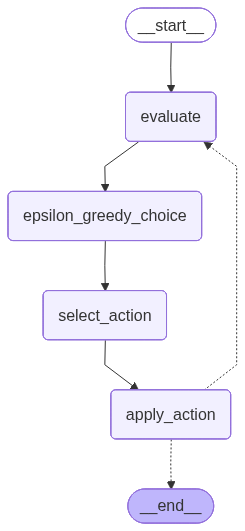

In [49]:
# Define the output formats for LLM nodes
class ActionOutputFormat(BaseModel):
    """Output format for the action selection step."""
    cot: str = Field(..., description="Chain of thought reasoning for the selected action.")
    action: str = Field(..., description="The selected action to apply to the current prompt.")

class ActionApplicationOutputFormat(BaseModel):
    """Output format for the action application step."""
    cot: str = Field(..., description="Chain of thought reasoning for the action application.")
    new_prompt: str = Field(..., description="The new prompt after applying the selected action.")

class InitialPromptOutputFormat(BaseModel):
    """Output format for the initial prompt."""
    sentiment: bool = Field(..., description="sentiment analysis of the text either positive/True or negarive/False")
    other: str = Field(..., description="Everything else requested by the prompt in string format.")

initial_prompt=PromptTemplateData(
    prompt="For the following given text return true if the sentiment is positive, otherwise return false. \nText: {text}",
    system_prompt="You are an expert in extracting the comment sentiment from the given text.",
    output_format=InitialPromptOutputFormat,
    prompt_format_function=lambda x, y: x.format(text=y)
)

# Initialize the PromptOptimizer with the initial prompt and evaluation method
po = PromptOptimizer(
    evaluation_method=evaluation_method,     # evaluation method for demonstration
    training_dataset=training_dataset,
    action_selection=PromptTemplateData(
        prompt="""Select an improvement action based on failure analysis: 
        Task:
        Sentiment analysis of movie reviews. If the movie review is positive, return true, otherwise return false.
        Current Prompt:
        {current_prompt}
        Performance Metrics:
        {performance_metrics}
        """,
        system_prompt=f"""You are an expert prompt engineer. Your task is to optimize prompts for the given task.
        You will be provided with a current prompt, performance metrics for the task, and a set of improvement actions.
        Your goal is to iteratively improve the prompt based on performance metrics and failure analysis.
        You will select an action to apply to the current prompt. A separate step will apply that action to generate a new prompt.
        Note that these actions will be used later to modify the prompt that an LLM will use to perform the task.
        The purpose of the afformentioned prompt is sentiment analysis of movie reviews.
        When choosing an action, consider the performance metrics and failure cases.
        Improvement actions you can choose from are:
        {', '.join(IMPROVEMENT_ACTIONS)}
        """,
        output_format=ActionOutputFormat,
        prompt_format_function=lambda **kwargs: kwargs['prompt'].format(**{k: v for k, v in kwargs.items() if k != 'prompt'})
    ),
    action_application=PromptTemplateData(
        prompt="""Apply the selected action to the prompt for the following task, and performance metrics:
        Task:
        Sentiment analysis of movie reviews. If the movie review is positive, return true, otherwise return false.
        prompt: 
        {selected_action} 
        Current Prompt: 
        {current_prompt}
        Performance Metrics:
        {performance_metrics}""",
        system_prompt=f"""You are a prompt engineer. 
        You are provided with a prompt which you will help improve such that an llm performs well on a given task. 
        Your job is to improve a prompt based on a preselection improvement action and a set of existing performance metrics performance metrics.
        You should provide the new prompt that results from applying the action that you are provided with to the current prompt.
        Make sure the new prompt is clear, concise, and effectively incorporates the selected improvement action.
        Do not change any other aspect of the prompt except for applying the selected improvement action.
        when applying the action, consider the performance metrics and failure cases.
        The improvement action you will be provided with will be one of the following: {', '.join(IMPROVEMENT_ACTIONS)}""",
        output_format=ActionApplicationOutputFormat,
        prompt_format_function=lambda **kwargs: kwargs['prompt'].format(**{k: v for k, v in kwargs.items() if k != 'prompt'})
    ),
    initial_prompt=PromptTemplateData(
        prompt="For the following given text return true if the sentiment is positive, otherwise return false. \nText: {text}",
        system_prompt="You are an expert in extracting the comment sentiment from the given text.",
        output_format=InitialPromptOutputFormat,
        prompt_format_function=lambda x, y: x.format(text=y)
    ),
    action_list=IMPROVEMENT_ACTIONS,
    train_test_ratio=0.8,
)

po.visualize()

In [50]:

final_state = po.run()

current prompt: For the following given text return true if the sentiment is positive, otherwise return false. 
Text: {text}
🔍 Evaluating prompt (iteration 0)


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

🎉 New best score: 0.933
🔍 Exploring - continuing with current prompt (ε=0.300)
🤖 Selecting improvement action
🎯 Selected action: Add examples
⚡ Applying action: Add examples
iteration: 0 | action: Add examples | training f1_score: 0.933 | validation f1_score: 0.889
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Here are some examples:

1. Text: "I absolutely loved this movie. The storyline was captivating and the performances were top-notch. Highly recommend!" 
   Expected Output: true

2. Text: "The film was a complete waste of time. The plot was dull and the acting was subpar. Definitely not recommended."
   Expected Output: false

Now, analyze the following text:
Text: {text}
🔍 Evaluating prompt (iteration 1)


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

🔍 Exploring - continuing with current prompt (ε=0.285)
🤖 Selecting improvement action
🎯 Selected action: Add examples
⚡ Applying action: Add examples
iteration: 1 | action: Add examples | training f1_score: 0.920 | validation f1_score: 0.882
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Here are some examples:

1. Text: "This film was a delightful surprise! The witty dialogue and charming characters kept me entertained throughout."
   Expected Output: true

2. Text: "I found the movie to be quite disappointing. The plot was predictable and the pacing was sluggish."
   Expected Output: false

3. Text: "An exhilarating ride from start to finish! The action scenes were brilliantly executed and left me on the edge of my seat."
   Expected Output: true

4. Text: "The movie failed to capture my interest. The storyline was convoluted and the characters were poorly developed."
   Expected Output: false

Now, analyze the followin

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.271)
🤖 Selecting improvement action
🎯 Selected action: Add specificity
⚡ Applying action: Add specificity
iteration: 2 | action: Add specificity | training f1_score: 0.900 | validation f1_score: 0.882
current prompt: For the following given text, analyze the sentiment. Return true if the sentiment is positive, focusing on keywords such as 'excellent', 'amazing', 'loved', or expressions of satisfaction and praise. Return false if the sentiment is negative or neutral, indicated by keywords like 'boring', 'disappointing', 'poor', or expressions of dissatisfaction and criticism. 
Text: {text}
🔍 Evaluating prompt (iteration 3)


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.257)
🤖 Selecting improvement action
🎯 Selected action: Add examples
⚡ Applying action: Add examples
iteration: 3 | action: Add examples | training f1_score: 0.885 | validation f1_score: 0.875
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false. Here are some examples to guide you:

Example 1:
Text: "The movie was a breathtaking masterpiece with stunning visuals and a gripping storyline. I was on the edge of my seat the entire time."
Output: true

Example 2:
Text: "This film was a complete waste of time. The plot was incoherent, and the acting was subpar. I wouldn't recommend it to anyone."
Output: false

Text: {text}
🔍 Evaluating prompt (iteration 4)


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.244)
🤖 Selecting improvement action
🎯 Selected action: Add Chain of Thought reasoning
⚡ Applying action: Add Chain of Thought reasoning
iteration: 4 | action: Add Chain of Thought reasoning | training f1_score: 0.933 | validation f1_score: 0.882
current prompt: For the following given text, analyze the sentiment by identifying positive or negative words and phrases. Consider the overall tone and context. Then, return true if the sentiment is positive, otherwise return false. 
Text: {text}
🔍 Evaluating prompt (iteration 5)


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.232)
🤖 Selecting improvement action
🎯 Selected action: Add specificity
⚡ Applying action: Add specificity
iteration: 5 | action: Add specificity | training f1_score: 0.900 | validation f1_score: 0.857
current prompt: For the following given text, return true if the sentiment is positive, characterized by praise, positive emotions, or strong recommendations. Otherwise, return false.
Text: {text}
🔍 Evaluating prompt (iteration 6)


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.221)
🤖 Selecting improvement action
🎯 Selected action: Add Chain of Thought reasoning
⚡ Applying action: Add Chain of Thought reasoning
iteration: 6 | action: Add Chain of Thought reasoning | training f1_score: 0.920 | validation f1_score: 0.857
current prompt: For the following given text, determine whether the sentiment is positive or negative by considering the tone, language, and overall message. Return true if the sentiment is positive, otherwise return false. Explain your reasoning step-by-step before providing the final answer.
Text: {text}
🔍 Evaluating prompt (iteration 7)


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.210)
🤖 Selecting improvement action
🎯 Selected action: Add examples
⚡ Applying action: Add examples
iteration: 7 | action: Add examples | training f1_score: 0.900 | validation f1_score: 0.824
current prompt: For the following given text, return true if the sentiment is positive, otherwise return false.

Examples:
1. Text: "I absolutely loved this movie! The storyline was gripping and the acting was top-notch."
   Output: true
2. Text: "The film was a complete waste of time. I regret watching it."
   Output: false
3. Text: "What an amazing experience! The visuals were stunning and the plot was very engaging."
   Output: true
4. Text: "I didn't enjoy this movie at all. The plot was dull and predictable."
   Output: false

Text: {text}
🔍 Evaluating prompt (iteration 8)


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

💰 Exploiting - using best known prompt (ε=0.199)
🤖 Selecting improvement action
🎯 Selected action: Add Chain of Thought reasoning
⚡ Applying action: Add Chain of Thought reasoning
iteration: 8 | action: Add Chain of Thought reasoning | training f1_score: 0.920 | validation f1_score: 0.848
current prompt: For the following given text, think step-by-step about the sentiment expressed. Consider positive or negative language, the overall tone, and any nuanced expressions. Then, return true if the sentiment is positive, otherwise return false. 
Text: {text}
🔍 Evaluating prompt (iteration 9)


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

🔍 Exploring - continuing with current prompt (ε=0.189)
🤖 Selecting improvement action
🎯 Selected action: Add specificity
⚡ Applying action: Add specificity
iteration: 9 | action: Add specificity | training f1_score: 0.907 | validation f1_score: 0.857
🛑 Max iterations (10) reached


In [51]:
final_state

{'current_prompt': PromptTemplateData(prompt='For the following given text, analyze the sentiment step-by-step. Focus on identifying positive or negative language, the overall tone, expressions of satisfaction or dissatisfaction, and any emotional cues. Consider phrases that indicate enjoyment, praise, or happiness for positive sentiment, and criticism, disappointment, or unhappiness for negative sentiment. Then, return true if the sentiment is positive, otherwise return false. \nText: {text}', system_prompt='You are an expert in extracting the comment sentiment from the given text.', prompt_format_function=<function <lambda> at 0x7a0ecc87f490>, output_format=<class '__main__.InitialPromptOutputFormat'>),
 'evaluation_dataset':                                                     text  label
 30745  Othello is set to burn the eyes of the viewers...      0
 3510   Stan Laurel, it's been noted, first made a rea...      1
 37266  There are two things that I like about Elvira,...      1
 47